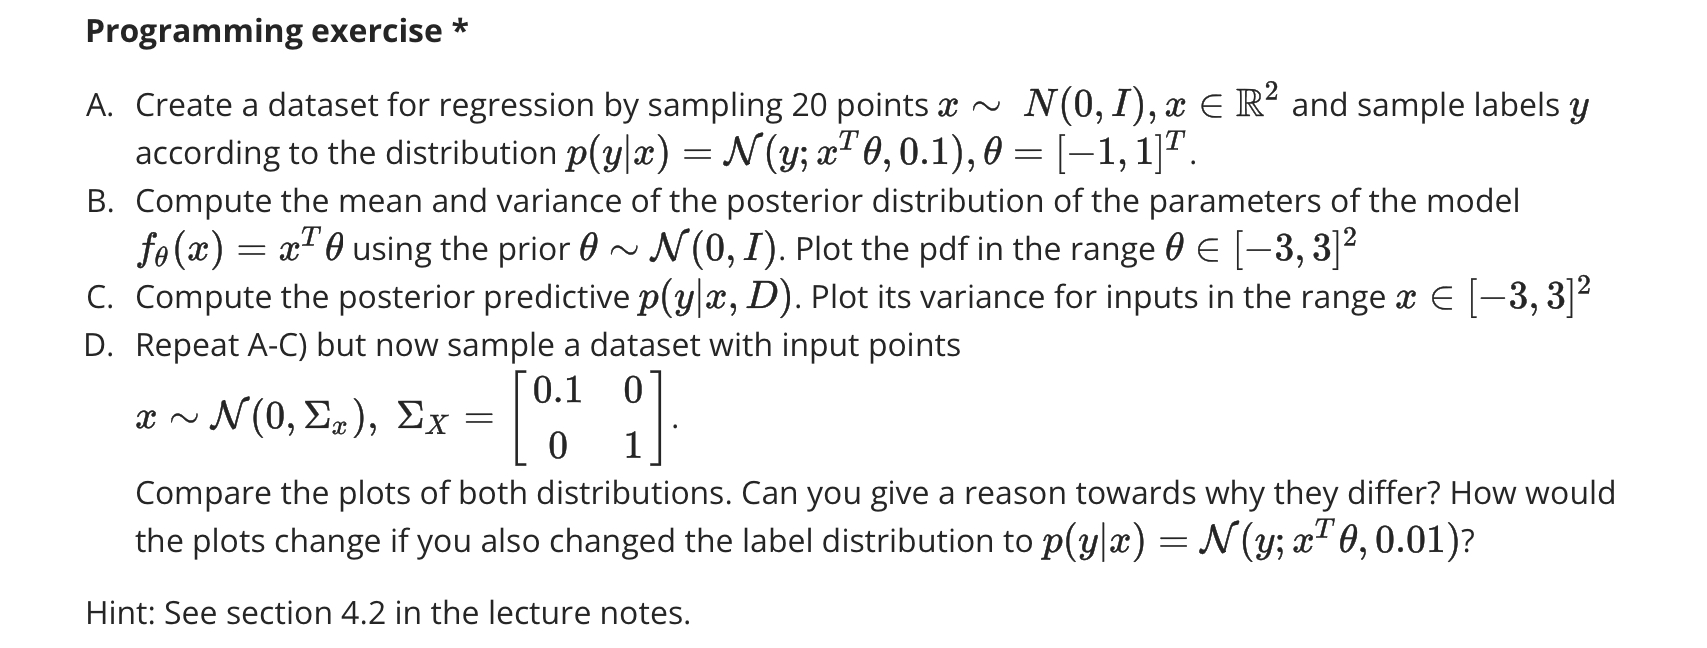

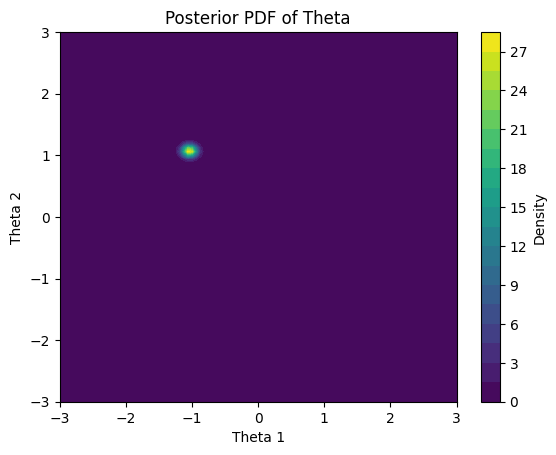

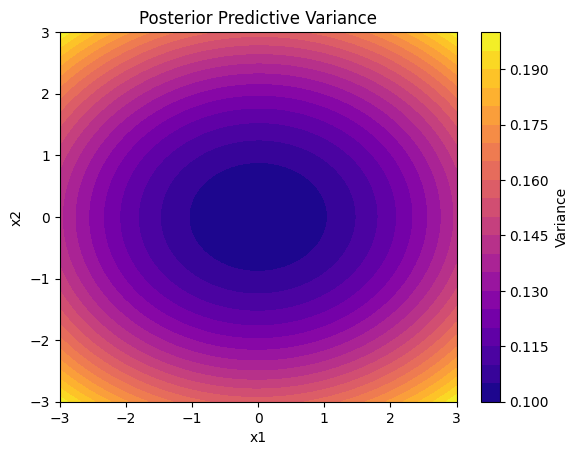

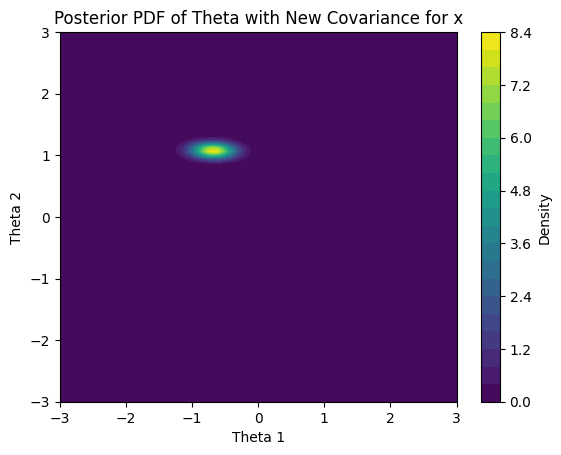

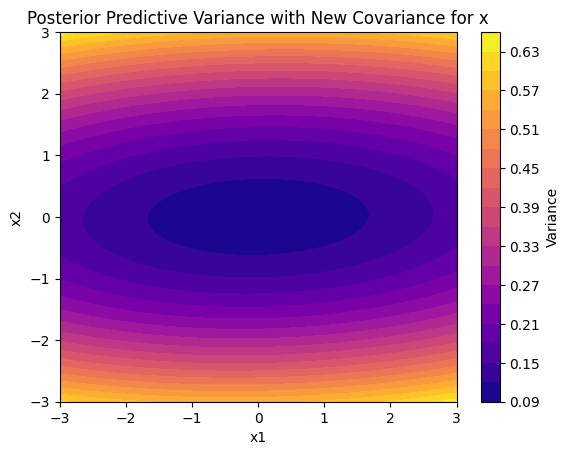

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Setting random seed for reproducibility
np.random.seed(42)

# Creating dataset for regression, sampling 20 points from N(0, I), x belongs to R^2 so we use multivariate normal
x = np.random.multivariate_normal(mean = [0,0], cov = np.eye(2), size = 20)

# Defining theta parameter as [-1, 1]^T
theta = np.array([-1, 1])

# Sampling labels y according to the distribution p(y|x) = N(y; x^T theta, 0.1)

# y_mean = x @ theta  # Mean is a dot product between x and theta
y = np.random.normal(loc = x @ theta, scale = np.sqrt(0.1), size = 20)

# Commputing the posterior distribution of the model parameters
# Setting prior theta as ~ N(0, I)
prior_mean = np.zeros(2)
prior_cov = np.eye(2)

# Computing the posterior mean and covariance: (X^T X / sigma^2 + prior_cov^-1)^-1
sigma2 = 0.1
X = x
posterior_cov = np.linalg.inv((X.T @ X) / sigma2 + np.linalg.inv(prior_cov))

# Posterior mean: posterior_cov @ (X^T y / sigma^2 + prior_cov^-1 @ prior_mean)
posterior_mean = posterior_cov @ (X.T @ y / sigma2 + np.linalg.inv(prior_cov) @ prior_mean)

# Plot the posterior pdf in the range theta ∈ [-3, 3]^2
THETA1, THETA2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
pos_pdf = np.zeros(THETA1.shape)

for i in range(THETA1.shape[0]):
    for j in range(THETA1.shape[1]):
        theta_ij = np.array([THETA1[i, j], THETA2[i, j]])
        pos_pdf[i, j] = multivariate_normal.pdf(theta_ij, mean=posterior_mean, cov=posterior_cov)

plt.contourf(THETA1, THETA2, pos_pdf, levels=20, cmap="viridis")
plt.title("Posterior PDF of Theta")
plt.xlabel("Theta 1")
plt.ylabel("Theta 2")
plt.colorbar(label="Density")
plt.show()

# Part C: Compute the posterior predictive p(y|x, D)
# Predictive mean and variance
x_range = np.linspace(-3, 3, 100)
x_grid = np.array([[x1, x2] for x1 in x_range for x2 in x_range])
predictive_mean = x_grid @ posterior_mean

predictive_variance = []
for x_i in x_grid:
    variance = x_i.T @ posterior_cov @ x_i + sigma2
    predictive_variance.append(variance)
predictive_variance = np.array(predictive_variance)

# Plot predictive variance for inputs in range x ∈ [-3, 3]^2
plt.contourf(x_range, x_range, predictive_variance.reshape(100, 100), levels=20, cmap="plasma")
plt.title("Posterior Predictive Variance")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(label="Variance")
plt.show()

# Part D: Repeat A-C with different covariance for x
# New covariance matrix for x
cov_x = np.array([[0.1, 0], [0, 1]])
x_new = np.random.multivariate_normal(mean=[0, 0], cov=cov_x, size=20)

# Repeat the same steps as A-C
# Sample labels y_new according to p(y|x_new) = N(y; x^T \theta, 0.1)
y_mean_new = x_new @ theta
y_new = np.random.normal(loc=y_mean_new, scale=np.sqrt(0.1), size=20)

# Posterior mean and covariance for new x
X_new = x_new
posterior_cov_new = np.linalg.inv((X_new.T @ X_new) / sigma2 + np.linalg.inv(prior_cov))
posterior_mean_new = posterior_cov_new @ (X_new.T @ y_new / sigma2 + np.linalg.inv(prior_cov) @ prior_mean)

# Plot new posterior pdf in the range theta ∈ [-3, 3]^2
pos_pdf_new = np.zeros(THETA1.shape)

for i in range(THETA1.shape[0]):
    for j in range(THETA1.shape[1]):
        theta_ij = np.array([THETA1[i, j], THETA2[i, j]])
        pos_pdf_new[i, j] = multivariate_normal.pdf(theta_ij, mean=posterior_mean_new, cov=posterior_cov_new)

plt.contourf(THETA1, THETA2, pos_pdf_new, levels=20, cmap="viridis")
plt.title("Posterior PDF of Theta with New Covariance for x")
plt.xlabel("Theta 1")
plt.ylabel("Theta 2")
plt.colorbar(label="Density")
plt.show()

# Posterior predictive for new inputs
predictive_mean_new = x_grid @ posterior_mean_new

predictive_variance_new = []
for x_i in x_grid:
    variance = x_i.T @ posterior_cov_new @ x_i + sigma2
    predictive_variance_new.append(variance)
predictive_variance_new = np.array(predictive_variance_new)

plt.contourf(x_range, x_range, predictive_variance_new.reshape(100, 100), levels=20, cmap="plasma")
plt.title("Posterior Predictive Variance with New Covariance for x")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(label="Variance")
plt.show()


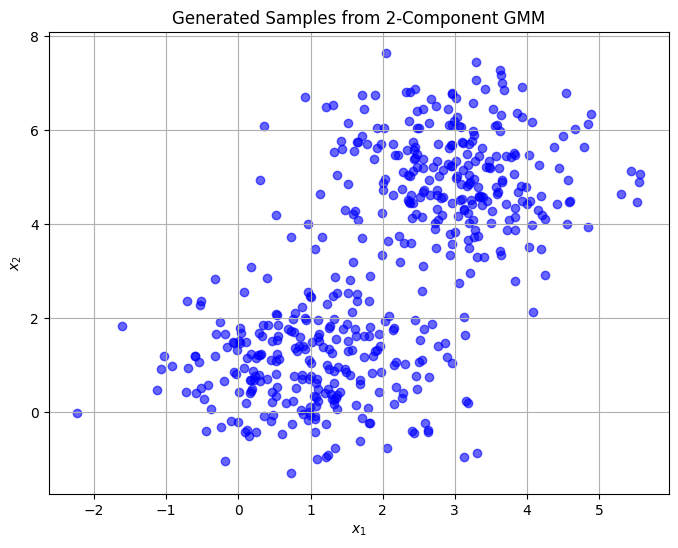

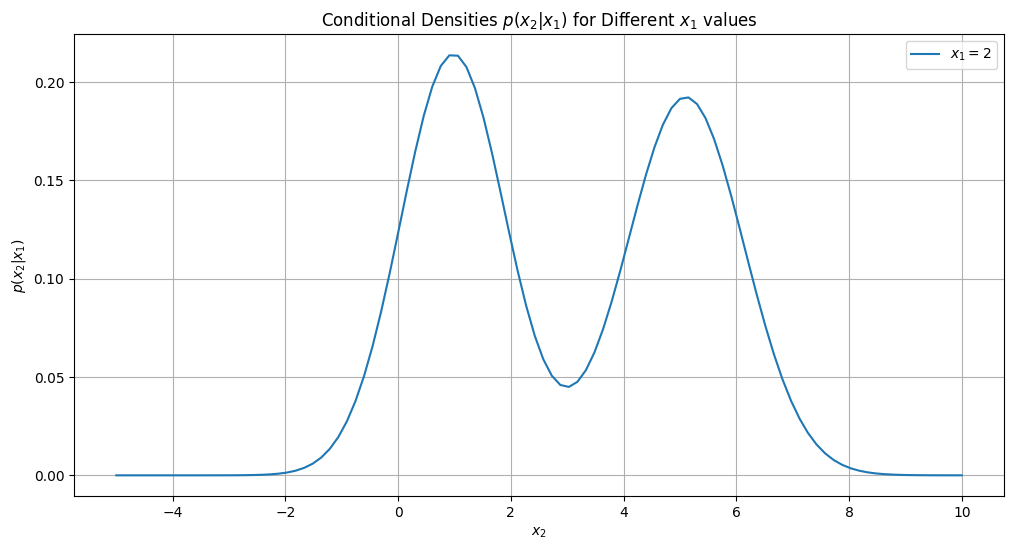

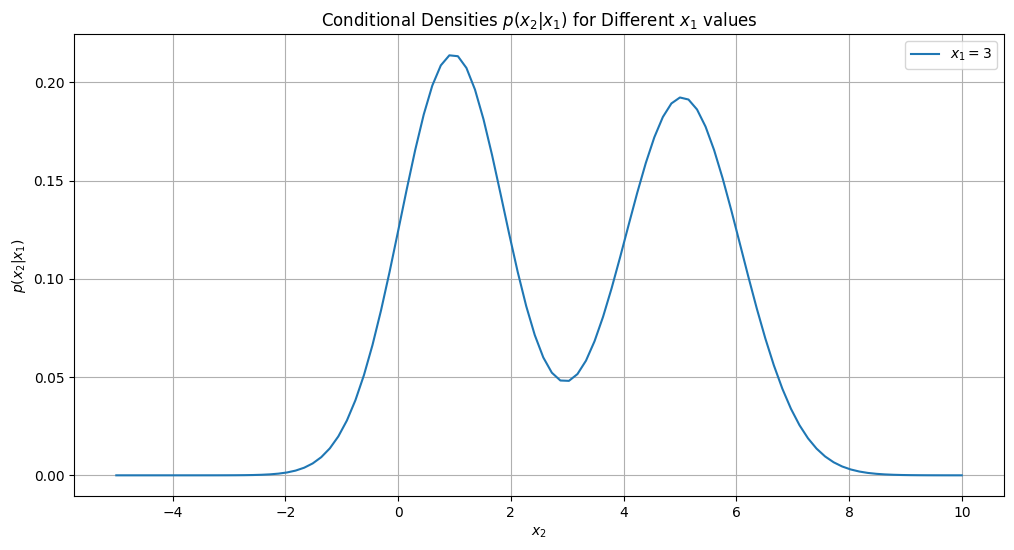

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Exercise 1: GMM and Conditional Mixture Model
# 1. Construct a 2-component GMM with means μ1 = [1, 1], μ2 = [3, 5], covariance identity, and mixing coefficients 1/2

np.random.seed(42)

# Define means and covariances
means = [np.array([1, 1]), np.array([3, 5])]
cov = np.eye(2)
weights = [0.5, 0.5]

# Number of samples
n_samples = 500

# Generate samples from each Gaussian component
samples = []
for weight, mean in zip(weights, means):
    n = int(weight * n_samples)
    samples.append(np.random.multivariate_normal(mean, cov, n))

# Stack all samples
samples = np.vstack(samples)

# Plot the generated samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, color='blue')
plt.title('Generated Samples from 2-Component GMM')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid()
plt.show()

# Fit a Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(samples)

# 2. Write a function to plot conditional density p(x2 | x1)
def conditional_density(gmm, x1_values):
    x2_grid = np.linspace(-5, 10, 100)
    plt.figure(figsize=(12, 6))
    for x1 in x1_values:
        conditional_means = []
        conditional_variances = []
        for mean, cov in zip(gmm.means_, gmm.covariances_):
            cond_mean = mean[1] + cov[1, 0] / cov[0, 0] * (x1 - mean[0])
            cond_var = cov[1, 1] - (cov[1, 0] ** 2) / cov[0, 0]
            conditional_means.append(cond_mean)
            conditional_variances.append(cond_var)

        mixture_density = sum(weights[i] * multivariate_normal.pdf(x2_grid, conditional_means[i], conditional_variances[i])
                             for i in range(len(weights)))
        plt.plot(x2_grid, mixture_density, label=f'$x_1={x1}$')

    plt.xlabel('$x_2$')
    plt.ylabel('$p(x_2 | x_1)$')
    plt.title('Conditional Densities $p(x_2 | x_1)$ for Different $x_1$ values')
    plt.legend()
    plt.grid()
    plt.show()

conditional_density(gmm, x1_values=[2])
conditional_density(gmm, x1_values=[3])

Epoch 1, Loss: 201.92985110677083
Epoch 2, Loss: 176.82462581380207
Epoch 3, Loss: 171.37175040690104
Epoch 4, Loss: 168.20272501627605
Epoch 5, Loss: 165.95537405598958
Epoch 6, Loss: 164.29241822916666
Epoch 7, Loss: 162.9320490234375
Epoch 8, Loss: 161.79709838867188
Epoch 9, Loss: 160.91068107096353
Epoch 10, Loss: 160.16105859375


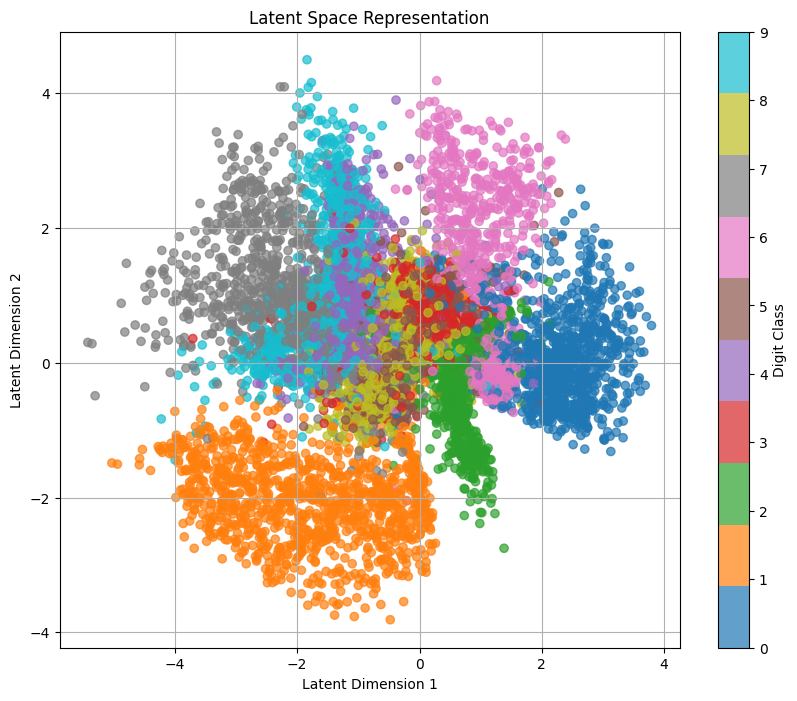

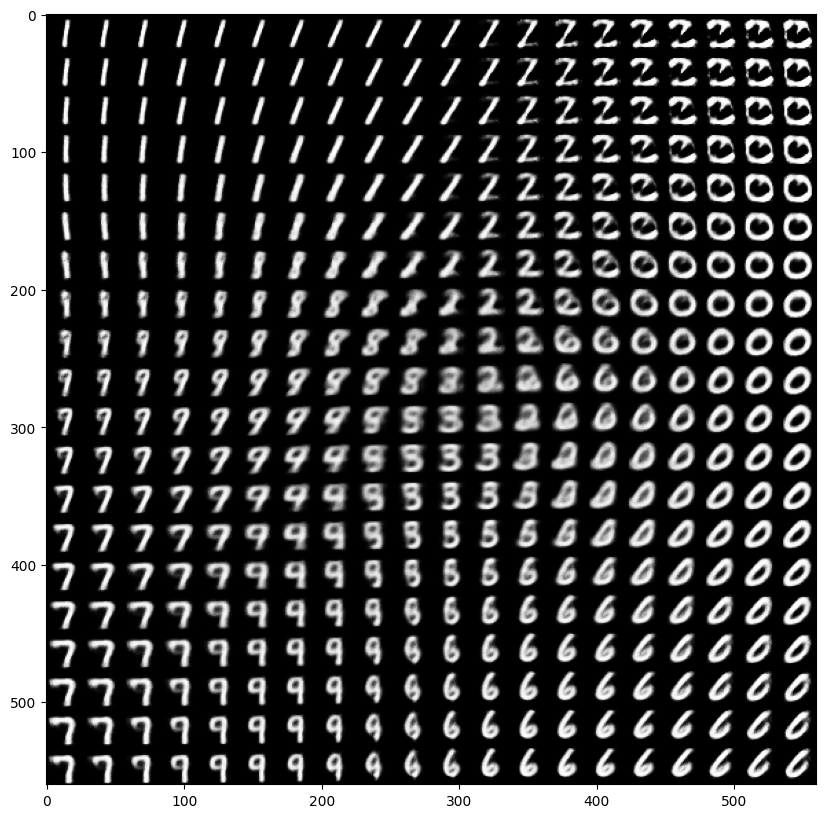

In [8]:
# Exercise 2: VAE on binarized MNIST dataset

# Setting up data loaders
def get_data_loaders(batch_size):
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        lambda x: x>0,
                        lambda x: x.float(),
              ])),
      batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        lambda x: x>0,
                        lambda x: x.float(),
                    ])),
      batch_size=batch_size, shuffle=True)
  return train_loader, test_loader


batch_size = 128
train_loader, test_loader = get_data_loaders(batch_size)

# VAE model class taken from this source: https://github.com/pytorch/examples/blob/main/vae/main.py
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)  # Latent space has dimension 2
        self.fc22 = nn.Linear(400, 2)
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(torch.device('cpu'))
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss = nn.functional.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

# Training the model on 10 epochs
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch)



#Visualizing encoded samples in the latent space:
def plot_latent_space(model, data_loader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(torch.device('cpu'))
            mu, _ = model.encode(data.view(-1, 784))
            latents.append(mu.numpy())
            labels.append(target.numpy())

    # Combine all batches
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plot the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Class')
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid()
    plt.show()

# Plotting the latent space
plot_latent_space(model, test_loader)


# Visualizing the latent space similarly to here: https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/result_manifold.png
# Creating a 2D grid and decoding
with torch.no_grad():
    nx, ny = 20, 20
    grid_x = np.linspace(-3, 3, nx)
    grid_y = np.linspace(-3, 3, ny)
    figure = np.zeros((28 * ny, 28 * nx))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]]).float()
            x_decoded = model.decode(z_sample).view(28, 28).numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = x_decoded

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()